<a id='Content'></a> 
### <b> Content </b>
1. [Import libraries](#Import-libraries)
2. [Upload and standardise data](#Upload-and-standardise-data)
3. [Define precitors and outcomes](#Define-precitors-and-outcomes)
4. [Mask missing values](#Mask-missing-values)
5. [Define and fit the model](#Define-and-fit-the-model)
6. [Run inferences and compute posterior distributions](#Run-inferences-and-compute-posterior-distributions)
7. [Convert and store traces in Arviz format](#Convert-and-store-traces-in-Arviz-format)
8. [Plot traces](#Plot-traces)
9. [Check statistical summary of the traces](#Check-statistical-summary-of-the-traces)
10. [Posterior predictive check](#Posterior-predictive-check)
11. [Results](#Results)

### Import libraries

In [1]:
# --- Import libraries --- #
import pandas as pd
import numpy as np
from patsy import dmatrices, dmatrix
from scipy import stats
from scipy.special import expit as logistic
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import balanced_accuracy_score, accuracy_score 
from sklearn.metrics import confusion_matrix
# matthews_corrcoef, f1_score, recall_score, precision_score

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import seaborn as sns

import theano
import theano.tensor as tt
import pymc3 as pm
import arviz as az

import warnings
warnings.simplefilter(action="ignore")
%config InlineBackend.figure_format = 'retina'

print("Packages uploaded successfully!")

Packages uploaded successfully!


[Back](#Content)

### Upload and standardise data

In [2]:
# --- Read data --- #
data = pd.read_csv('../data/machine_readable.csv')

# --- Standardise continuous values --- #
data_prep = data[['LogD', 'Cbrain/Cblood','Syn_EC30', 
                  'Syn_Viability_EC30', 'NNF_EC50min', 'NNF_EC50max', 'NNF_LDH_EC50', 'NNF_AB_EC50']]
sc = StandardScaler()
data_scaled = sc.fit_transform(data_prep)
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['LogD', 'Cbrain/Cblood','Syn_EC30', 
                       'Syn_Viability_EC30', 'NNF_EC50min', 'NNF_EC50max', 'NNF_LDH_EC50', 'NNF_AB_EC50']

# Add other discrete values and details
discrete = data [['Chemical', 'CASRN', 'DNT', 'BBB', 'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active', 
  'BDNF_Reduction', 'Activity_Syn', 'Activity_NNF']]
data = discrete.join(data_scaled, lsuffix="_left", rsuffix="_right")

# Print transformed data
data.head()

,Chemical,CASRN,DNT,BBB,Pgp_inhibition,Pgp_substrate,Pgp_active,BDNF_Reduction,Activity_Syn,Activity_NNF,LogD,Cbrain/Cblood,Syn_EC30,Syn_Viability_EC30,NNF_EC50min,NNF_EC50max,NNF_LDH_EC50,NNF_AB_EC50
0,1-2-Propyleneglycol,57-55-6,0,1.0,0.0,0.0,0.0,NaN,0,0,-0.748758,-0.441041,NaN,NaN,NaN,NaN,NaN,NaN
1,5-Fluorouracil,51-21-8,1,1.0,0.0,0.0,0.0,1.0,1,1,-0.916255,-0.500081,NaN,3.343773,-0.219477,-0.161475,-0.182496,-0.600731
2,Acetaminophen,103-90-2,0,1.0,0.0,0.0,0.0,1.0,0,0,-0.316312,-0.390045,NaN,NaN,NaN,NaN,NaN,NaN
3,Acetamiprid,135410-20-7,1,1.0,0.0,0.0,0.0,NaN,0,0,-0.115316,-0.368014,NaN,NaN,NaN,NaN,NaN,NaN
4,Acrylamide,79-06-1,1,1.0,0.0,0.0,0.0,1.0,0,1,-0.642169,-0.452132,NaN,NaN,0.114719,-0.135961,NaN,NaN


[Back](#Content)

### Define precitors and outcomes

In [3]:
# --- Define predictors and outcomes --- #

# BDNF given by continuous and discrete variables
x_bdnf = pd.DataFrame(data[['LogD', 'Cbrain/Cblood', 'BBB', 
                            'Pgp_inhibition', 'Pgp_substrate', 'Pgp_active']]).values
y_bdnf = pd.DataFrame(data[['BDNF_Reduction']]).values

# SYN
x_syn = pd.DataFrame(data[['Syn_EC30', 'Syn_Viability_EC30']]).values
Y_syn = pd.DataFrame(data[['Activity_Syn']]).values #Y because no missing values

# NNF
x_nnf = pd.DataFrame(data[['NNF_EC50min', 'NNF_EC50max', 'NNF_LDH_EC50', 'NNF_AB_EC50']]).values
Y_nnf = pd.DataFrame(data[['Activity_NNF']]).values #Y because no missing values

# x_dnt is given by causal relations BDNF->SYN->NNF->DNT<-BNDF
Y_dnt = pd.DataFrame(data[['DNT']]).values #Y because no missing values

[Back](#Content)

### Mask missing values

In [4]:
# --- Mask missing data --- #
# BDNF
x_bdnf_missing = np.isnan(x_bdnf)
X_bdnf_train = np.ma.masked_array(x_bdnf, mask=x_bdnf_missing)
y_bdnf_missing = np.isnan(y_bdnf)
Y_bdnf_train = np.ma.masked_array(y_bdnf, mask=y_bdnf_missing)

# SYN
x_syn_missing = np.isnan(x_syn)
X_syn_train = np.ma.masked_array(x_syn, mask=x_syn_missing)

# NNF
x_nnf_missing = np.isnan(x_nnf)
X_nnf_train = np.ma.masked_array(x_nnf, mask=x_nnf_missing)

[Back](#Content)

### Define and fit the model

In [5]:
# --- Define and fit the model --- #
with pm.Model() as model_hierar:
    # Define hyperpriors
    mu_beta = pm.Normal('mu_beta', mu=0, sd=0.01) 
    sd_beta = pm.HalfNormal('sd_beta', sd=1)
    # Define priors
    beta_bdnf = pm.Normal('beta_bdnf', mu=mu_beta, sd=sd_beta, shape=(6,1))
    beta_syn = pm.Normal('beta_syn', mu=mu_beta, sd=sd_beta, shape=(2,1))
    beta_nnf = pm.Normal('beta_nnf', mu=mu_beta, sd=sd_beta, shape=(4,1))
    
    
    # Imputation of X missing values for BDNF
    Xmu_bdnf = pm.Normal('Xmu_bdnf', mu=0, sd=0.01, shape=(1,6))
    Xsigma_bdnf = pm.HalfNormal('Xsigma_bdnf', sd=1, shape=(1,6))
    X_bdnf_modelled = pm.Normal('X_bdnf_modelled', 
                                         mu=Xmu_bdnf, sigma=Xsigma_bdnf, observed=X_bdnf_train)

    # Likelihood for BDNF
    # SLogP, Cbrain/Cblood, BBB, Pgp->BDNF
    lp_bdnf = pm.Deterministic('lp_bdnf', pm.math.dot(X_bdnf_modelled, beta_bdnf))
    y_obs_bdnf = pm.Bernoulli('y_obs_bdnf', logit_p=lp_bdnf, observed=Y_bdnf_train)
    
    # Imputation of X missing values for SYN
    Xmu_syn = pm.Normal('Xmu_syn', mu=0, sd=0.01, shape=(1,2))
    Xsigma_syn = pm.HalfNormal('Xsigma_syn', sd=1, shape=(1,2))
    X_syn_modelled = pm.Normal('X_syn_modelled',
                                 mu=Xmu_syn, sigma=Xsigma_syn, observed=X_syn_train)

    # Likelihood for SYN
    # BDNF->SYN
    lp_syn = pm.Deterministic('lp_syn', lp_bdnf + pm.math.dot(X_syn_modelled, beta_syn))
    y_obs_syn = pm.Bernoulli("y_obs_syn", logit_p=lp_syn, observed=Y_syn)
    
    # Imputation of X missing values for NNF
    Xmu_nnf = pm.Normal('Xmu_nnf', mu=0, sd=0.01, shape=(1,4))
    Xsigma_nnf = pm.HalfNormal('Xsigma_nnf', sd=1, shape=(1,4)) 
    X_nnf_modelled = pm.Normal('X_nnf_modelled',
                                 mu=Xmu_nnf, sd=Xsigma_nnf, observed=X_nnf_train)
   
    # Likelihood for NNF
    # BDNF->SYN->NNF
    lp_nnf = pm.Deterministic('lp_nnf', lp_syn + pm.math.dot(X_nnf_modelled, beta_nnf))
    y_obs_nnf = pm.Bernoulli("y_obs_nnf", logit_p=lp_nnf, observed=Y_nnf)
    
    # Define causal relationships for DNT
    lp_dnt = pm.Deterministic('lp_dnt', lp_bdnf + lp_syn + lp_nnf)
    y_obs_dnt = pm.Bernoulli('y_obs_dnt', logit_p=lp_dnt, observed=Y_dnt)

In [6]:
# Checking the proposed structure of model
model_hierar.check_test_point()

mu_beta                      3.69
sd_beta_log__               -0.77
beta_bdnf                   -4.16
beta_syn                    -1.39
beta_nnf                    -2.77
Xmu_bdnf                    22.12
Xsigma_bdnf_log__           -4.62
X_bdnf_modelled_missing      0.00
y_obs_bdnf_missing           0.00
Xmu_syn                      7.37
Xsigma_syn_log__            -1.54
X_syn_modelled_missing       0.00
Xmu_nnf                     14.74
Xsigma_nnf_log__            -3.08
X_nnf_modelled_missing       0.00
X_bdnf_modelled           -552.12
y_obs_bdnf                 -61.00
X_syn_modelled            -172.26
y_obs_syn                  -61.00
X_nnf_modelled            -394.00
y_obs_nnf                  -61.00
y_obs_dnt                  -61.00
Name: Log-probability of test_point, dtype: float64

[Back](#Content)

### Run inferences and compute posterior distributions

In [7]:
# --- Run inferences and compute posterior distributions --- #
with model_hierar:
    trace_hierar = pm.sample(cores=4, draws=10000, nuts={'target_accept':0.90})
    #Predictions
    posterior_hierar = pm.sample_posterior_predictive(trace_hierar)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [X_nnf_modelled_missing, Xsigma_nnf, Xmu_nnf, X_syn_modelled_missing, Xsigma_syn, Xmu_syn, X_bdnf_modelled_missing, Xsigma_bdnf, Xmu_bdnf, beta_nnf, beta_syn, beta_bdnf, sd_beta, mu_beta]
>BinaryGibbsMetropolis: [y_obs_bdnf_missing]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 162 seconds.
The number of effective samples is smaller than 25% for some parameters.


[Back](#Content)

### Convert and store traces in Arviz format

In [8]:
# --- Convert and store traces in Arviz format --- #
idata_hierar = az.from_pymc3(trace=trace_hierar, 
                             posterior_predictive=posterior_hierar,
                             model=model_hierar)
idata_hierar

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

[Back](#Content)

### Plot traces

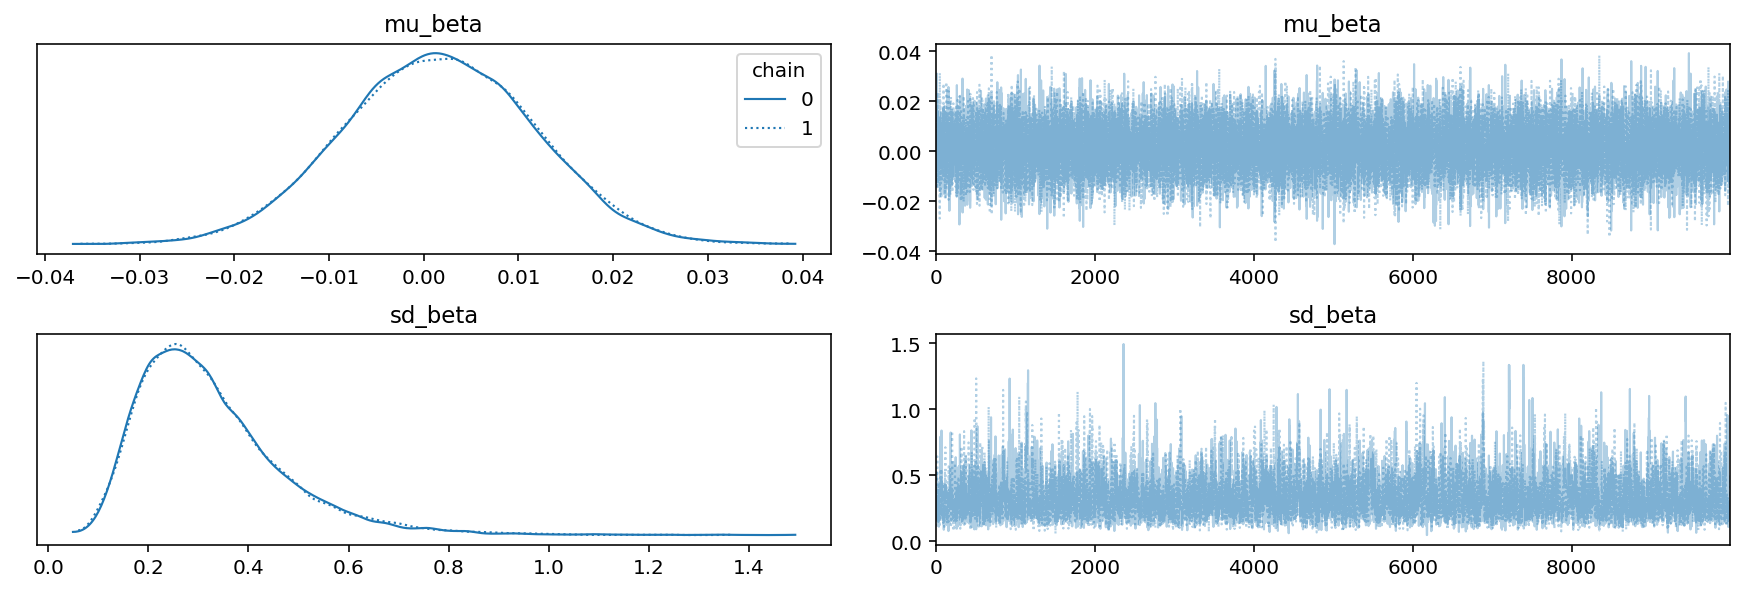

In [9]:
# --- Plot traces of two chains of hyperpriors --- #
pm.plot_trace(trace_hierar, var_names=['mu_beta', 'sd_beta'],
             coords={"chain":[0,1]}, legend=True);

[Back](#Content)

### Check statistical summary of the traces

In [10]:
# --- Check statistical summary --- #
# Mean, sd, hdi_2.5% and hdi_97.5% for an hdi of 95%, mcse_mean, mcse_sd, ess_bulk, ess_tail, and r_hat
stats = az.summary(trace_hierar, round_to=3, hdi_prob=0.95)
stats

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_beta,0.002,0.010,-0.018,0.021,0.000,0.000,49127.359,30409.224,1.0
"beta_bdnf[0,0]",0.090,0.103,-0.117,0.293,0.001,0.001,20687.542,24981.098,1.0
"beta_bdnf[1,0]",0.183,0.122,-0.033,0.439,0.001,0.001,19366.712,21323.594,1.0
"beta_bdnf[2,0]",0.399,0.127,0.165,0.659,0.001,0.001,9421.660,13183.172,1.0
"beta_bdnf[3,0]",0.025,0.259,-0.507,0.535,0.002,0.002,13309.080,11409.969,1.0
...,...,...,...,...,...,...,...,...,...
"lp_dnt[83,0]",1.941,1.106,-0.163,4.249,0.007,0.005,29711.410,28000.094,1.0
"lp_dnt[84,0]",1.641,0.904,-0.077,3.535,0.006,0.005,27045.004,21089.548,1.0
"lp_dnt[85,0]",1.298,1.397,-1.318,4.147,0.008,0.007,28978.573,25721.998,1.0
"lp_dnt[86,0]",0.762,0.541,-0.256,1.867,0.004,0.003,15863.917,21328.530,1.0


In [11]:
# --- Save the results --- #
trace_results = pd.DataFrame(stats)
trace_results = trace_results.to_csv('../data/trace_results.csv')

[Back](#Content)

### Posterior predictive check

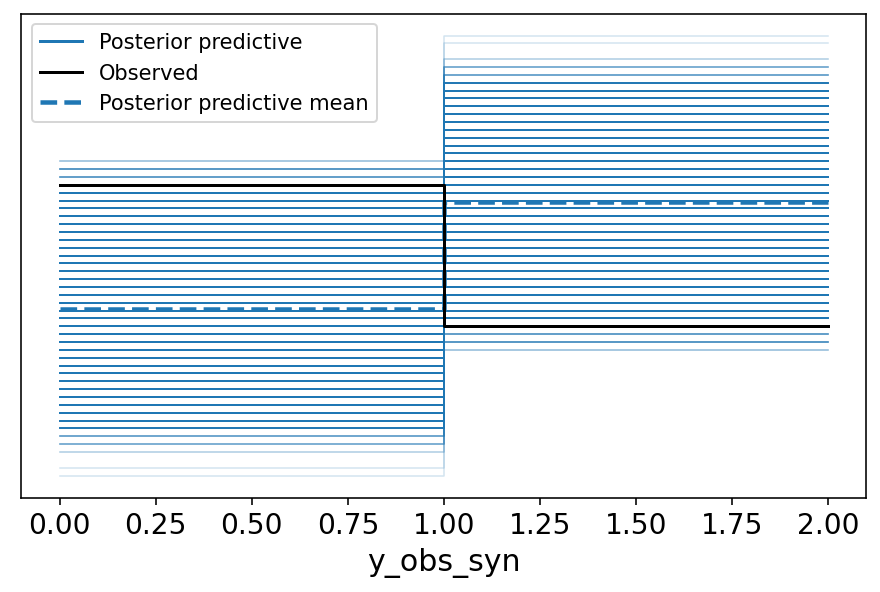

In [12]:
az.plot_ppc(idata_hierar, var_names=['y_obs_syn']);

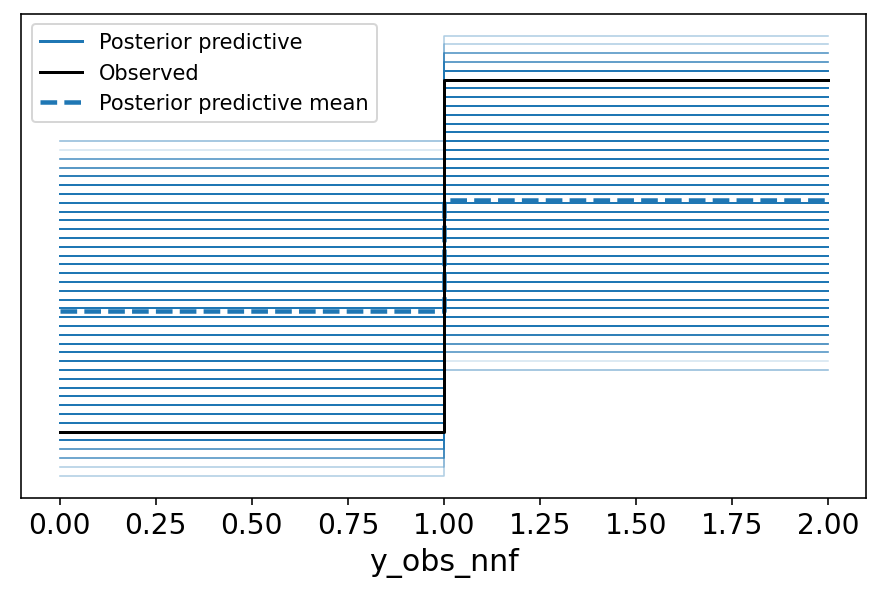

In [13]:
az.plot_ppc(idata_hierar, var_names=['y_obs_nnf']);

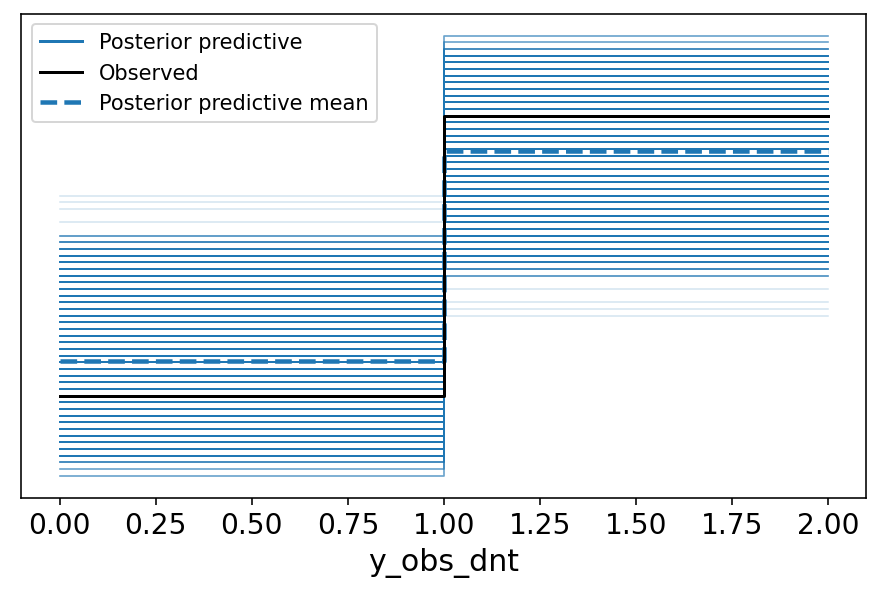

In [14]:
az.plot_ppc(idata_hierar, var_names=['y_obs_dnt']);

[Back](#Content)

### Results

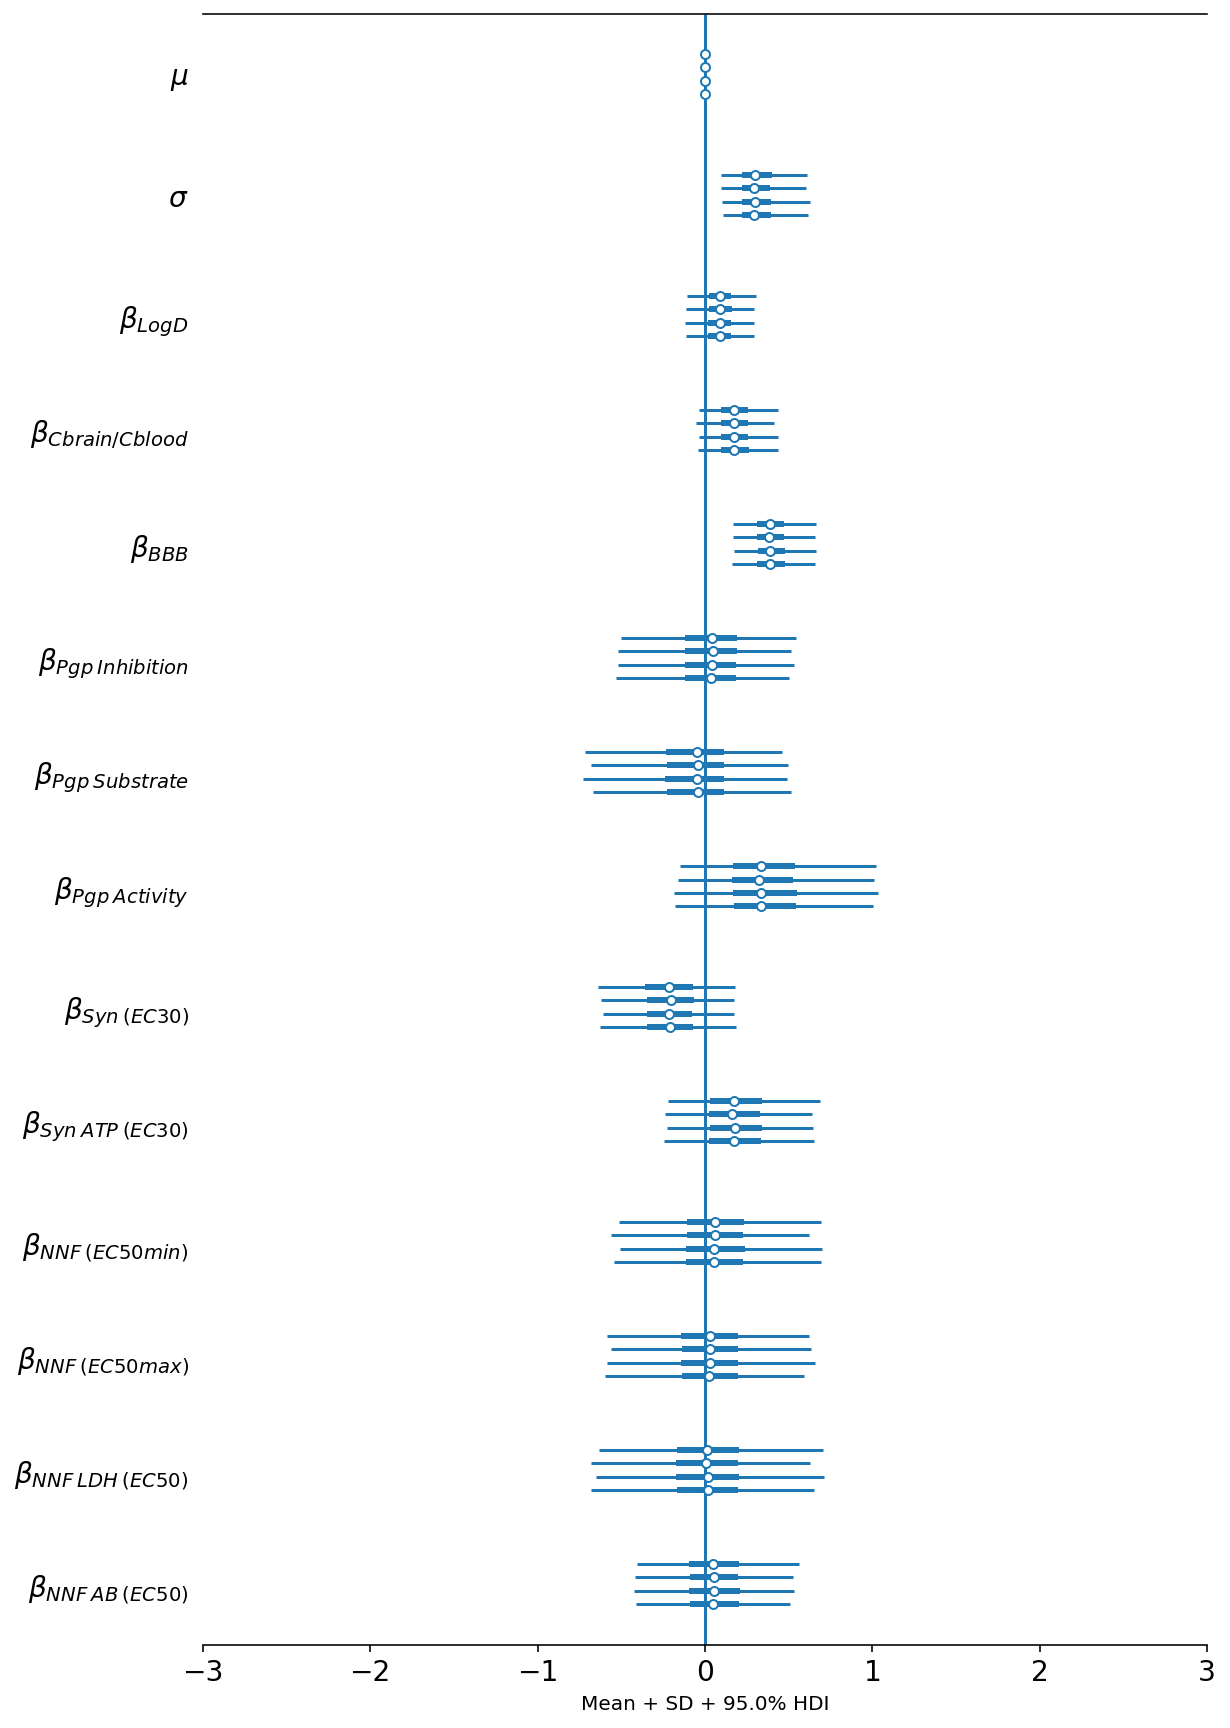

In [15]:
# --- Plot parameters for model_hierar --- #
fig, ax = plt.subplots(figsize=(9,15))
az.plot_forest(trace_hierar, var_names=['mu_beta', 'sd_beta','beta_bdnf', 'beta_syn', 'beta_nnf'],
                  hdi_prob=0.95, kind='forestplot', ax=ax)
ax.vlines(0., *ax.get_ylim());
ax.set_xlim([-3,3]);
ax.set_yticklabels((r'$\beta_{NNF\:AB\:(EC50)}$', r'$\beta_{NNF\:LDH\:(EC50)}$',
                       r'$\beta_{NNF\:(EC50max)}$', r'$\beta_{NNF\:(EC50min)}$', 
                       r'$\beta_{Syn\:ATP\:(EC30)}$', r'$\beta_{Syn\:(EC30)}$', 
                       r'$\beta_{Pgp\: Activity}$', r'$\beta_{Pgp\: Substrate}$', 
                       r'$\beta_{Pgp\: Inhibition}$', r'$\beta_{BBB}$', r'$\beta_{Cbrain/Cblood}$', 
                       r'$\beta_{LogD}$', r'$\sigma$', r'$\mu$'))
ax.set_xlabel('Mean + SD + 95.0% HDI')
ax.set_title("");

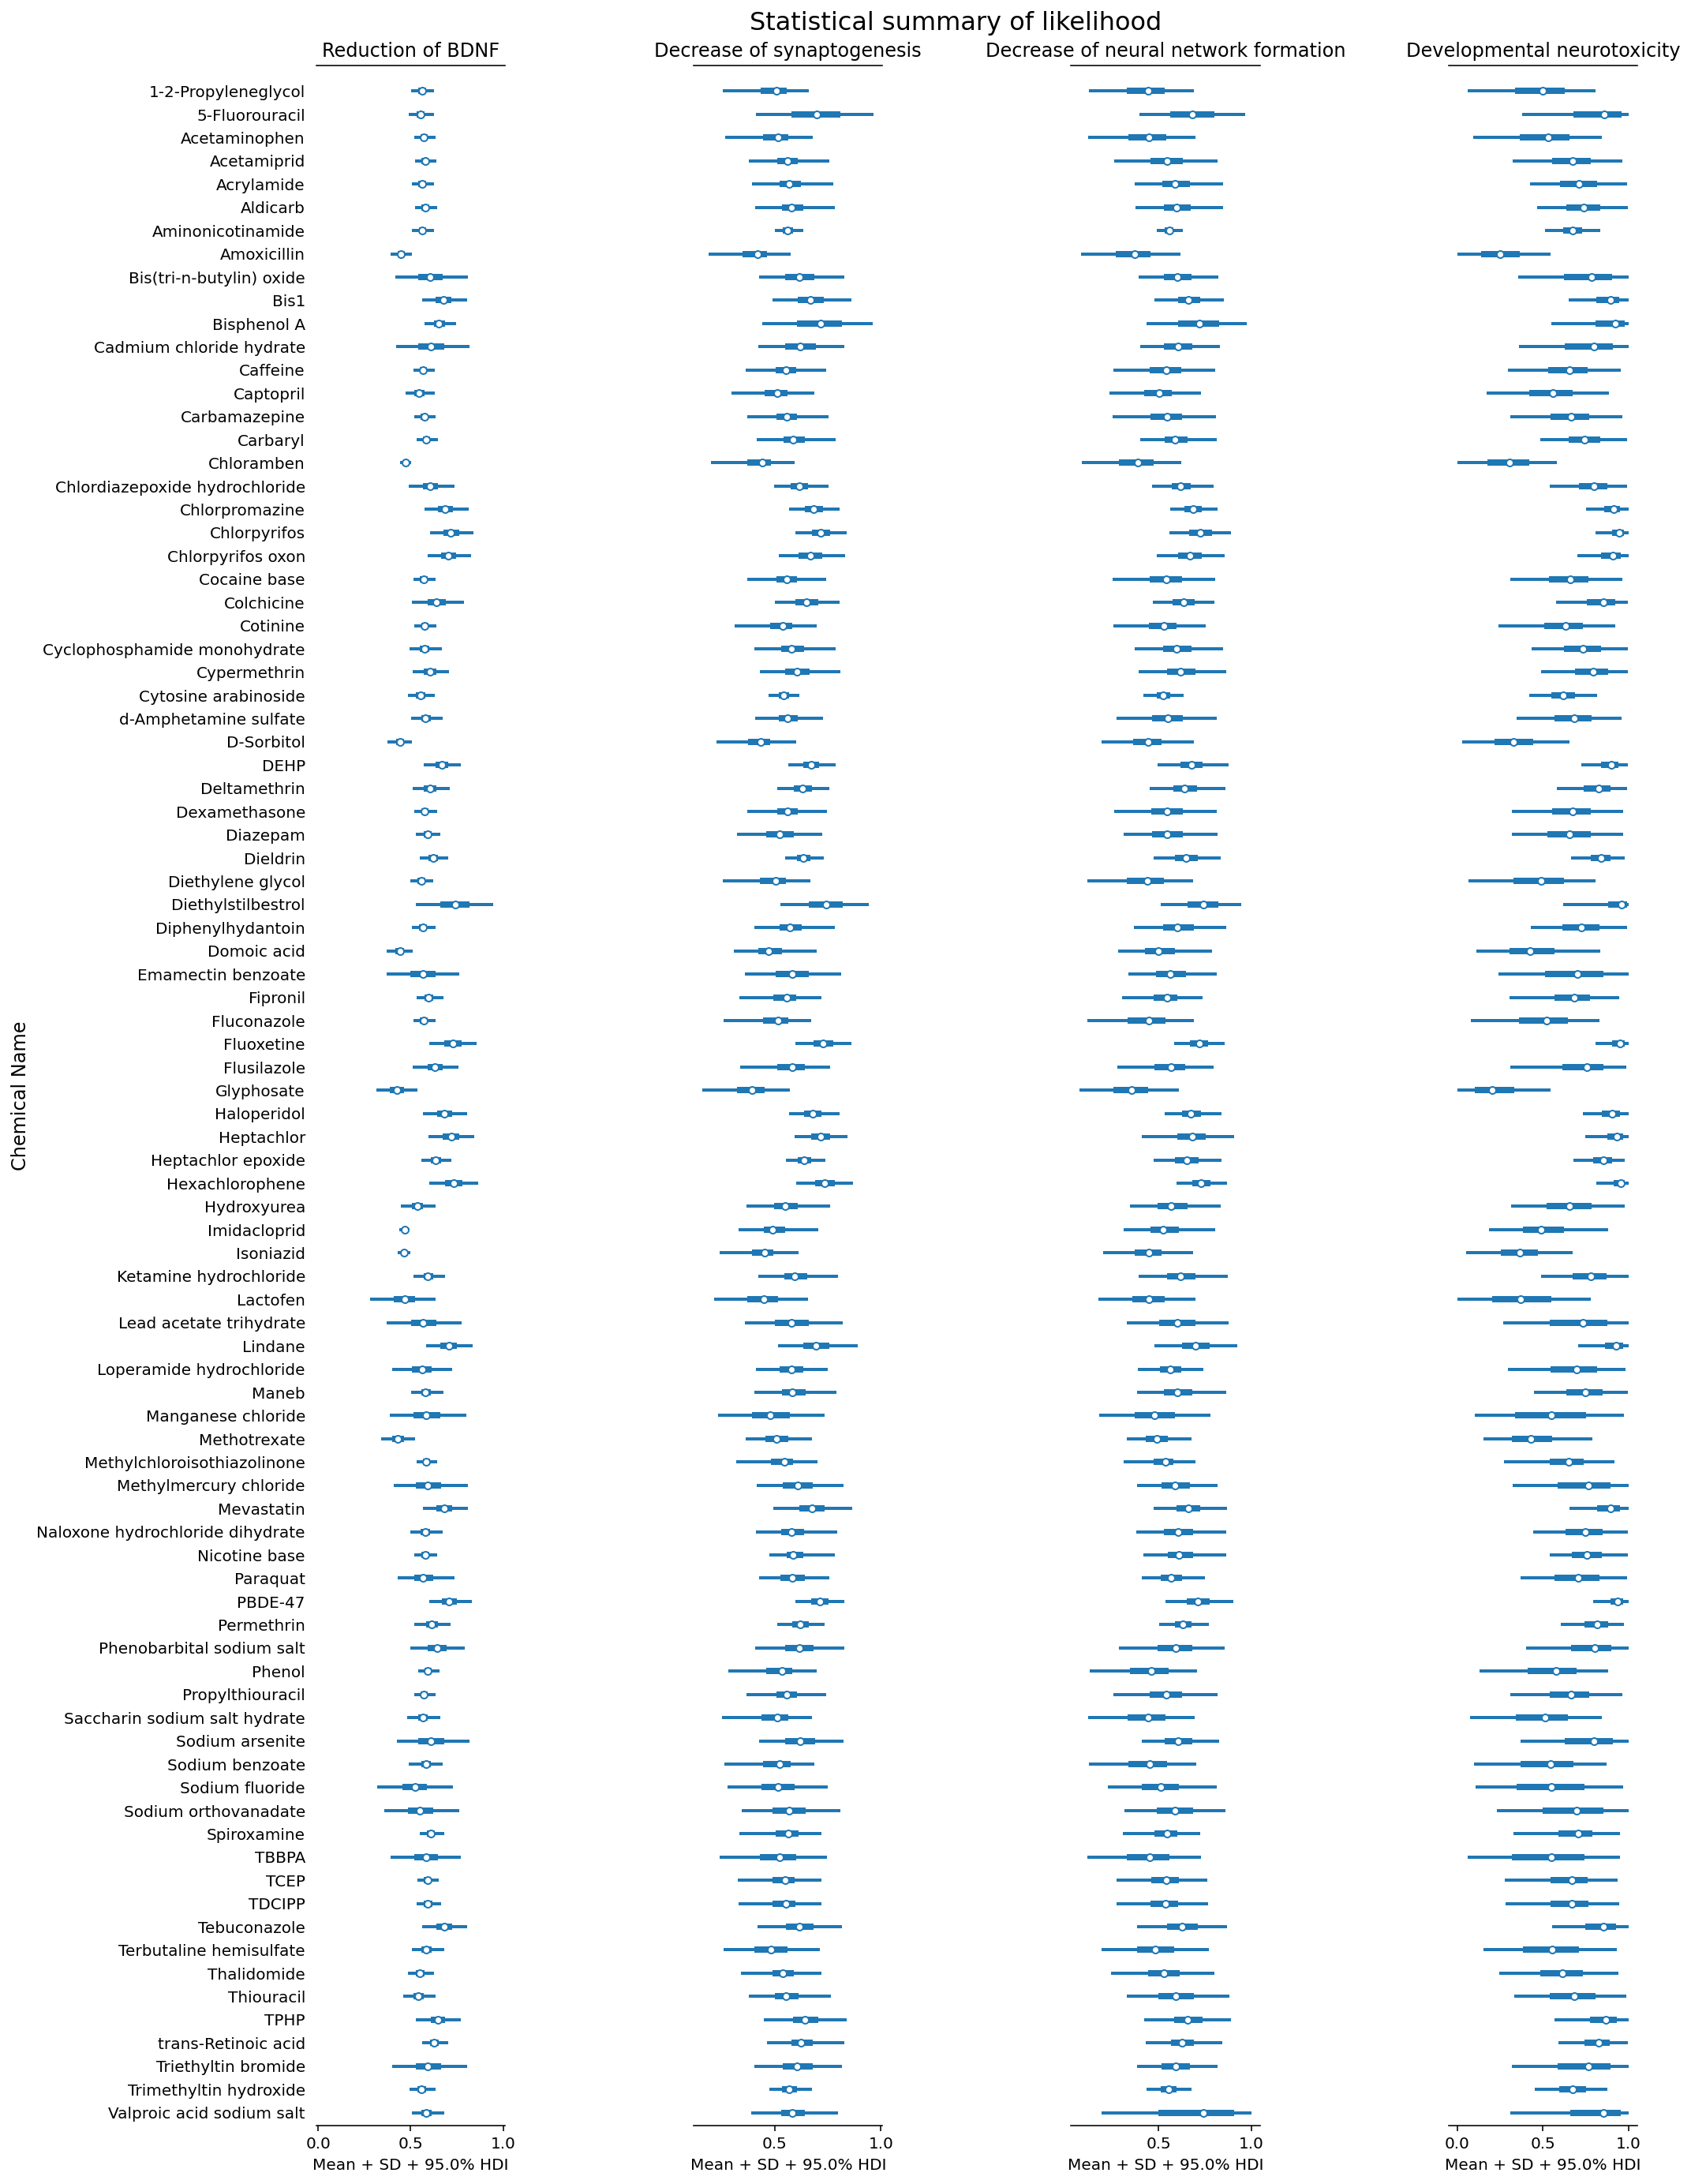

In [16]:
# --- Mean of posterior densities (likelihood function) --- #
ylabels= data["Chemical"].astype(str)
#ylabels= data["Chemical"].astype(str) + " (" + data["CASRN"].astype(str) + ")"

fig, ax = plt.subplots(1, 4, figsize=(15,24), sharey=True)


ax0 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_bdnf', combined=True, transform=logistic, linewidth=2, markersize=6,
                   hdi_prob=0.95, textsize=10, ax = ax[0])
ax1 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_syn', combined=True, transform=logistic, linewidth=2, markersize=6,
                   hdi_prob=0.95, textsize=10, ax = ax[1])

ax2 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_nnf', combined=True, transform=logistic, linewidth=2, markersize=6,
                   hdi_prob=0.95, textsize=10, ax = ax[2])
ax3 = pm.forestplot(idata_hierar.posterior, 
                   var_names='lp_dnt', combined=True, transform=logistic, linewidth=2, markersize=6,
                   hdi_prob=0.95, textsize=10, ax = ax[3])

ax[0].set_yticklabels(ylabels[::-1])

ax[0].set_xlim([-0.01,1.01])

for ax_ in ax:
    ax_.set_xlabel("Mean + SD + 95.0% HDI")

ax[0].set_ylabel("Chemical Name", fontsize=12)
ax[0].set_title("Reduction of BDNF", fontsize=12)
ax[1].set_title("Decrease of synaptogenesis", fontsize=12)
ax[2].set_title("Decrease of neural network formation", fontsize=12)
ax[3].set_title("Developmental neurotoxicity", fontsize=12);

plt.subplots_adjust(wspace=1)

plt.suptitle("Statistical summary of likelihood", y=0.9, fontsize=16);

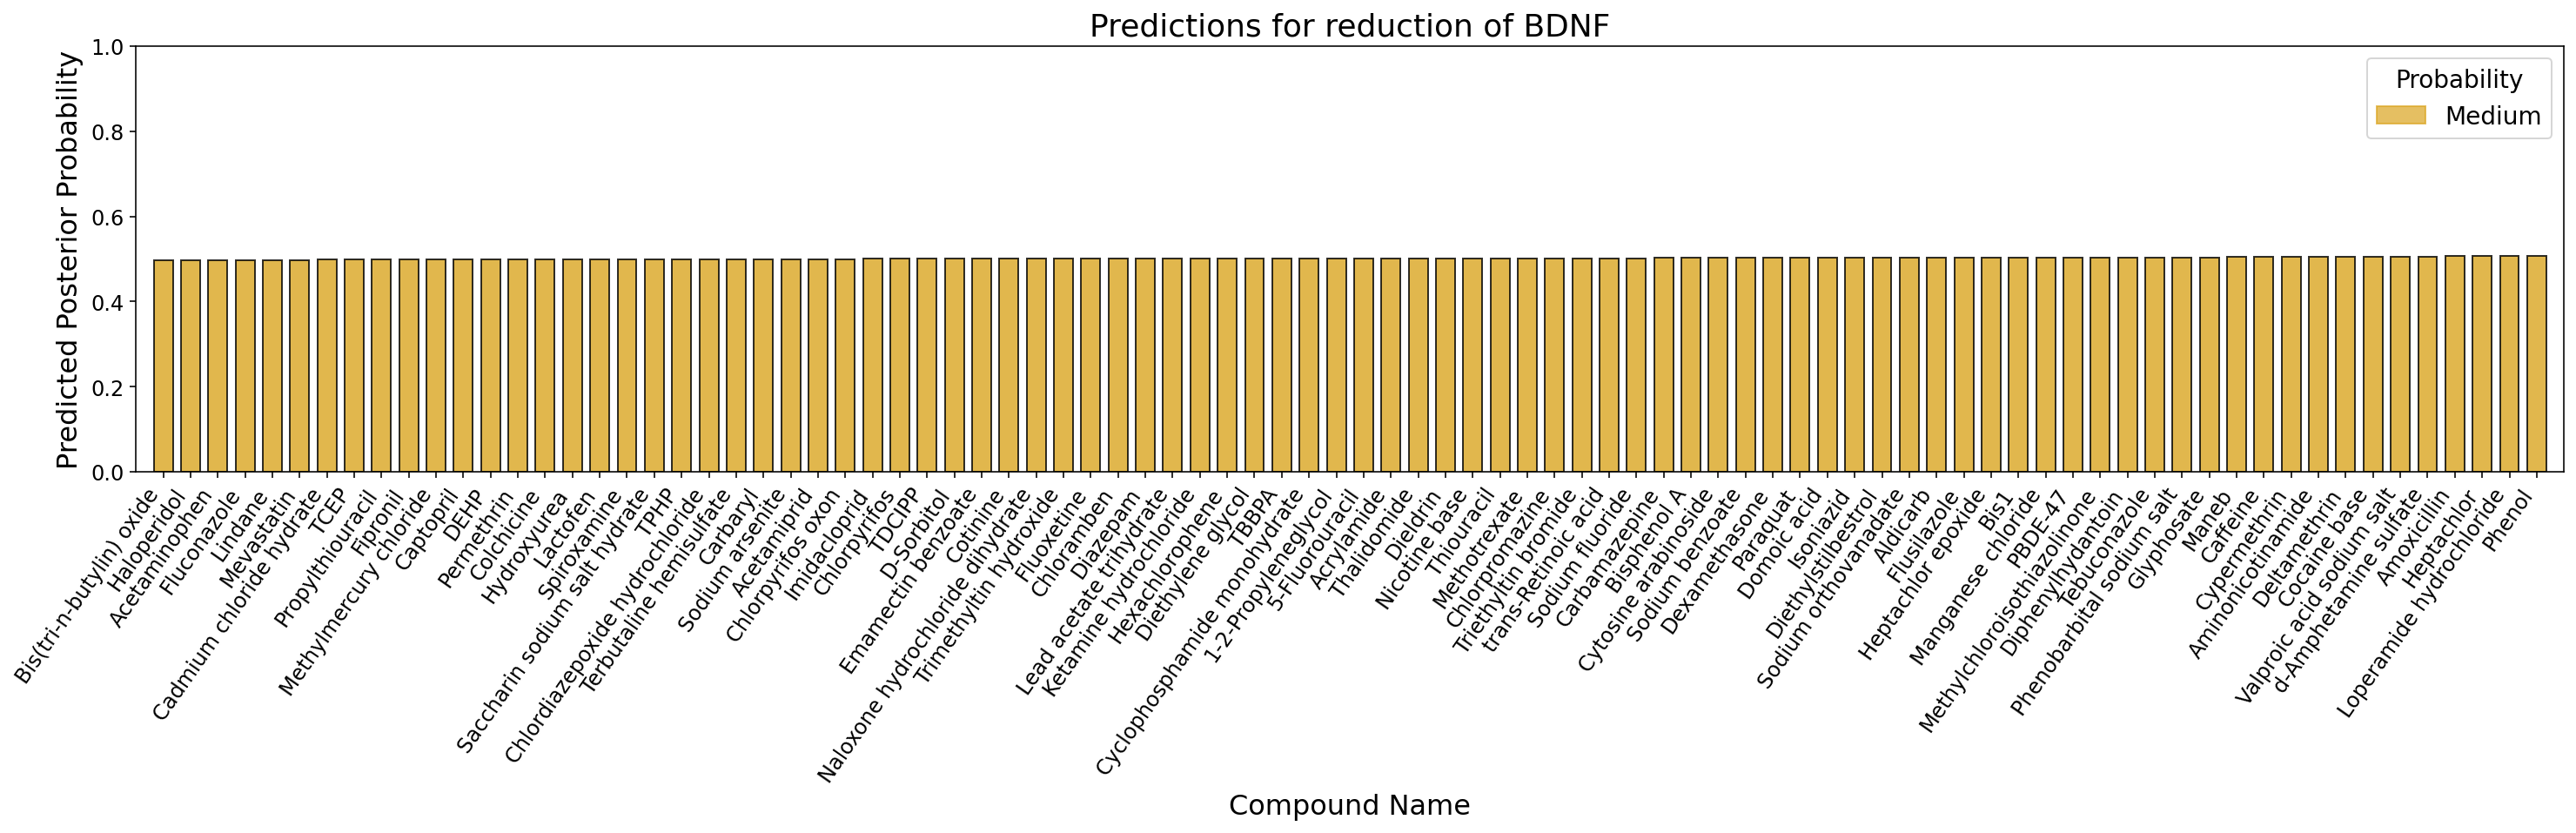

In [18]:
# --- Mean of posterior probabilities for BDNF --- #
ylabels= data["Chemical"].astype(str)

obs_bdnf = np.squeeze(idata_hierar.posterior_predictive['y_obs_bdnf'])
obs_pred = np.reshape(obs_bdnf.values, (40000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .34] = 0
new_labeling[(avg_obs_pred >= .34) & (avg_obs_pred < .67)] = 1
new_labeling[avg_obs_pred >= .67] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]

fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Predicted Posterior Probability', fontsize=16)
ax.set_xlabel('Compound Name', fontsize=16)
ax.set_title("Predictions for reduction of BDNF", fontsize=18)

ax.set_xlim([-1, 88])
ax.set_ylim([0, 1])

yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.7)
plt.legend(handles=[yellow_patch], title="Probability", title_fontsize=14, fontsize=14)

fig.autofmt_xdate(rotation=55);

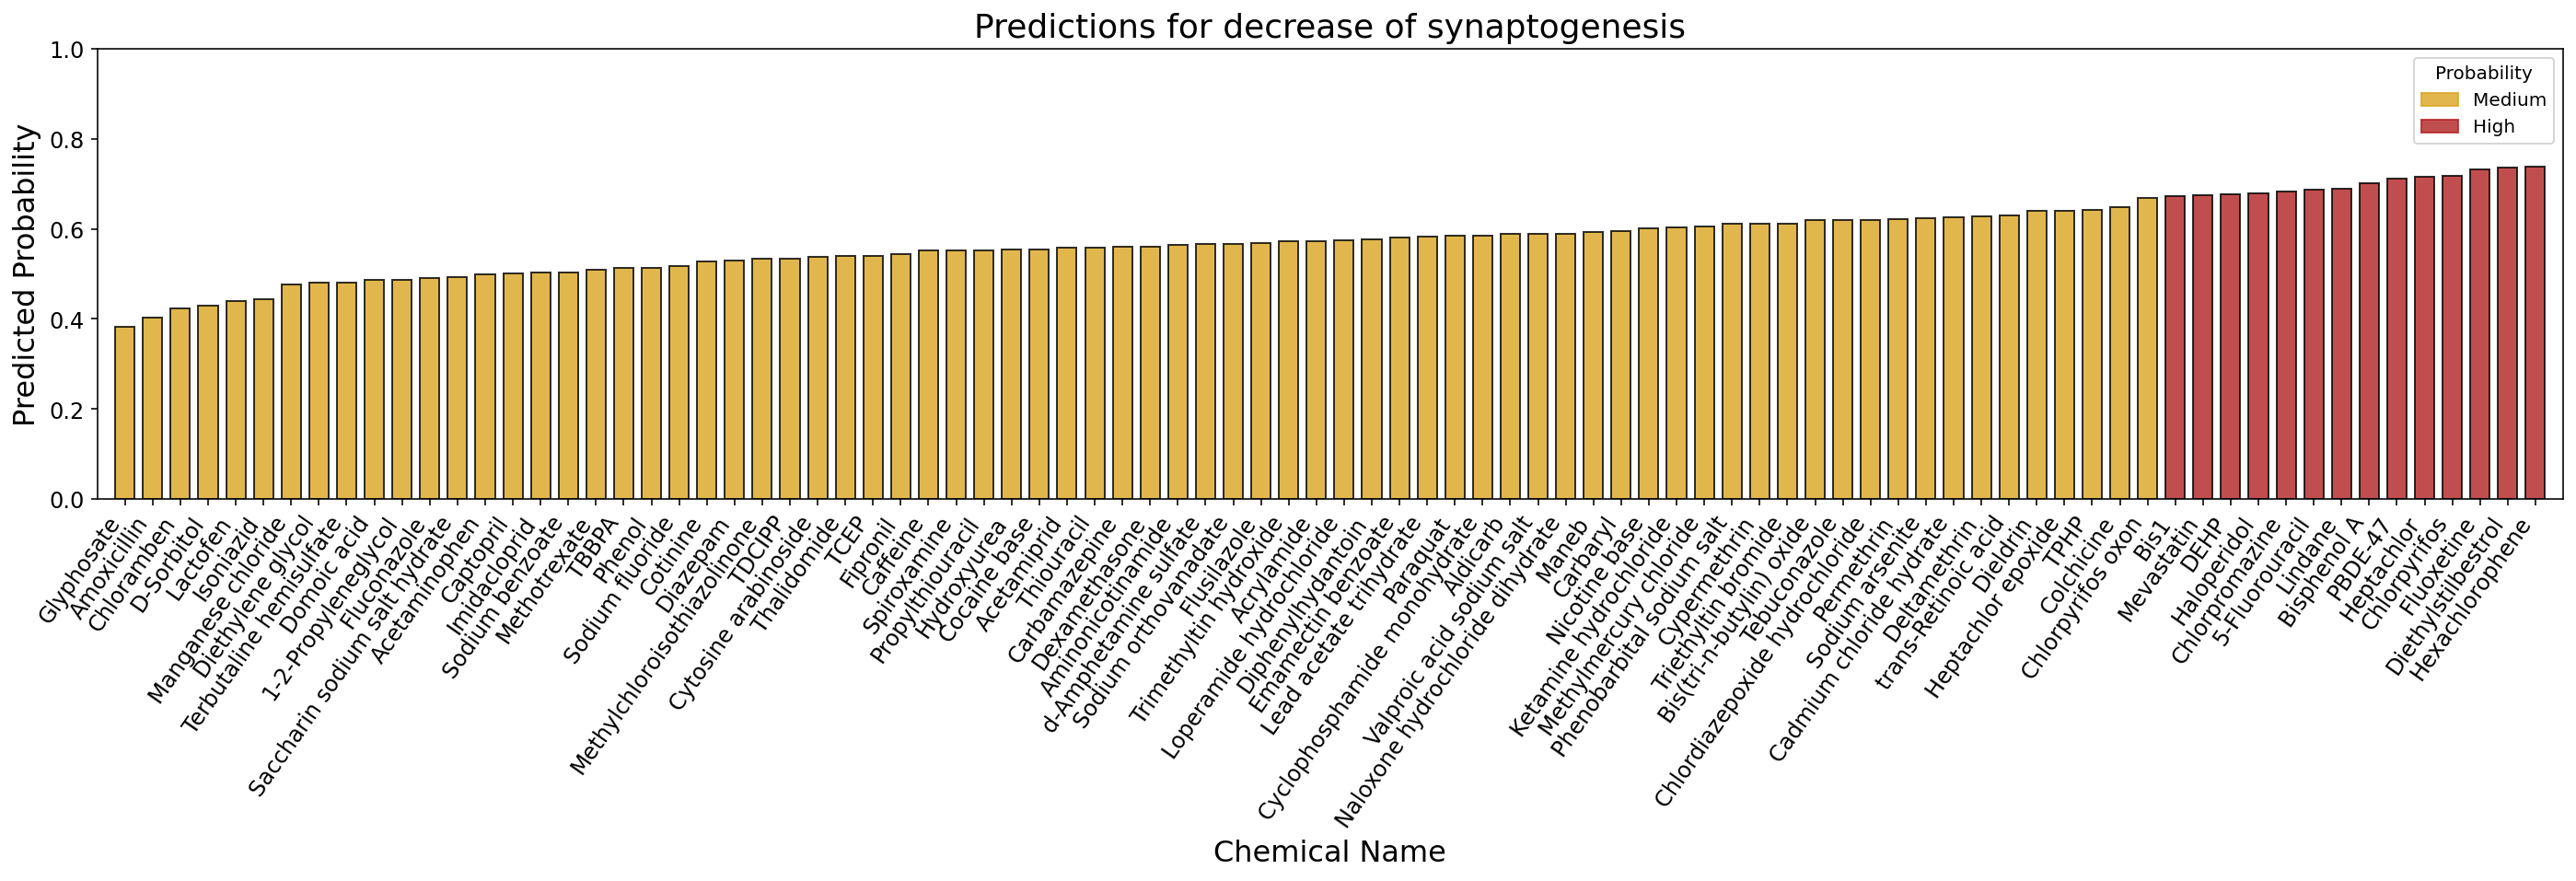

In [19]:
# --- Mean of posterior probabilities for SYN --- #
obs_syn = np.squeeze(idata_hierar.posterior_predictive['y_obs_syn'])
obs_pred = np.reshape(obs_syn.values, (40000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .34] = 0
new_labeling[(avg_obs_pred >= .34) & (avg_obs_pred < .67)] = 1
new_labeling[avg_obs_pred >= .67] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]


fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Chemical Name', fontsize=16)
ax.set_title("Predictions for decrease of synaptogenesis", fontsize=18)

ax.set_xlim([-1, 88])
ax.set_ylim([0, 1])

yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.8)
red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.8)
plt.legend(handles=[yellow_patch, red_patch], title="Probability")

fig.autofmt_xdate(rotation=55);

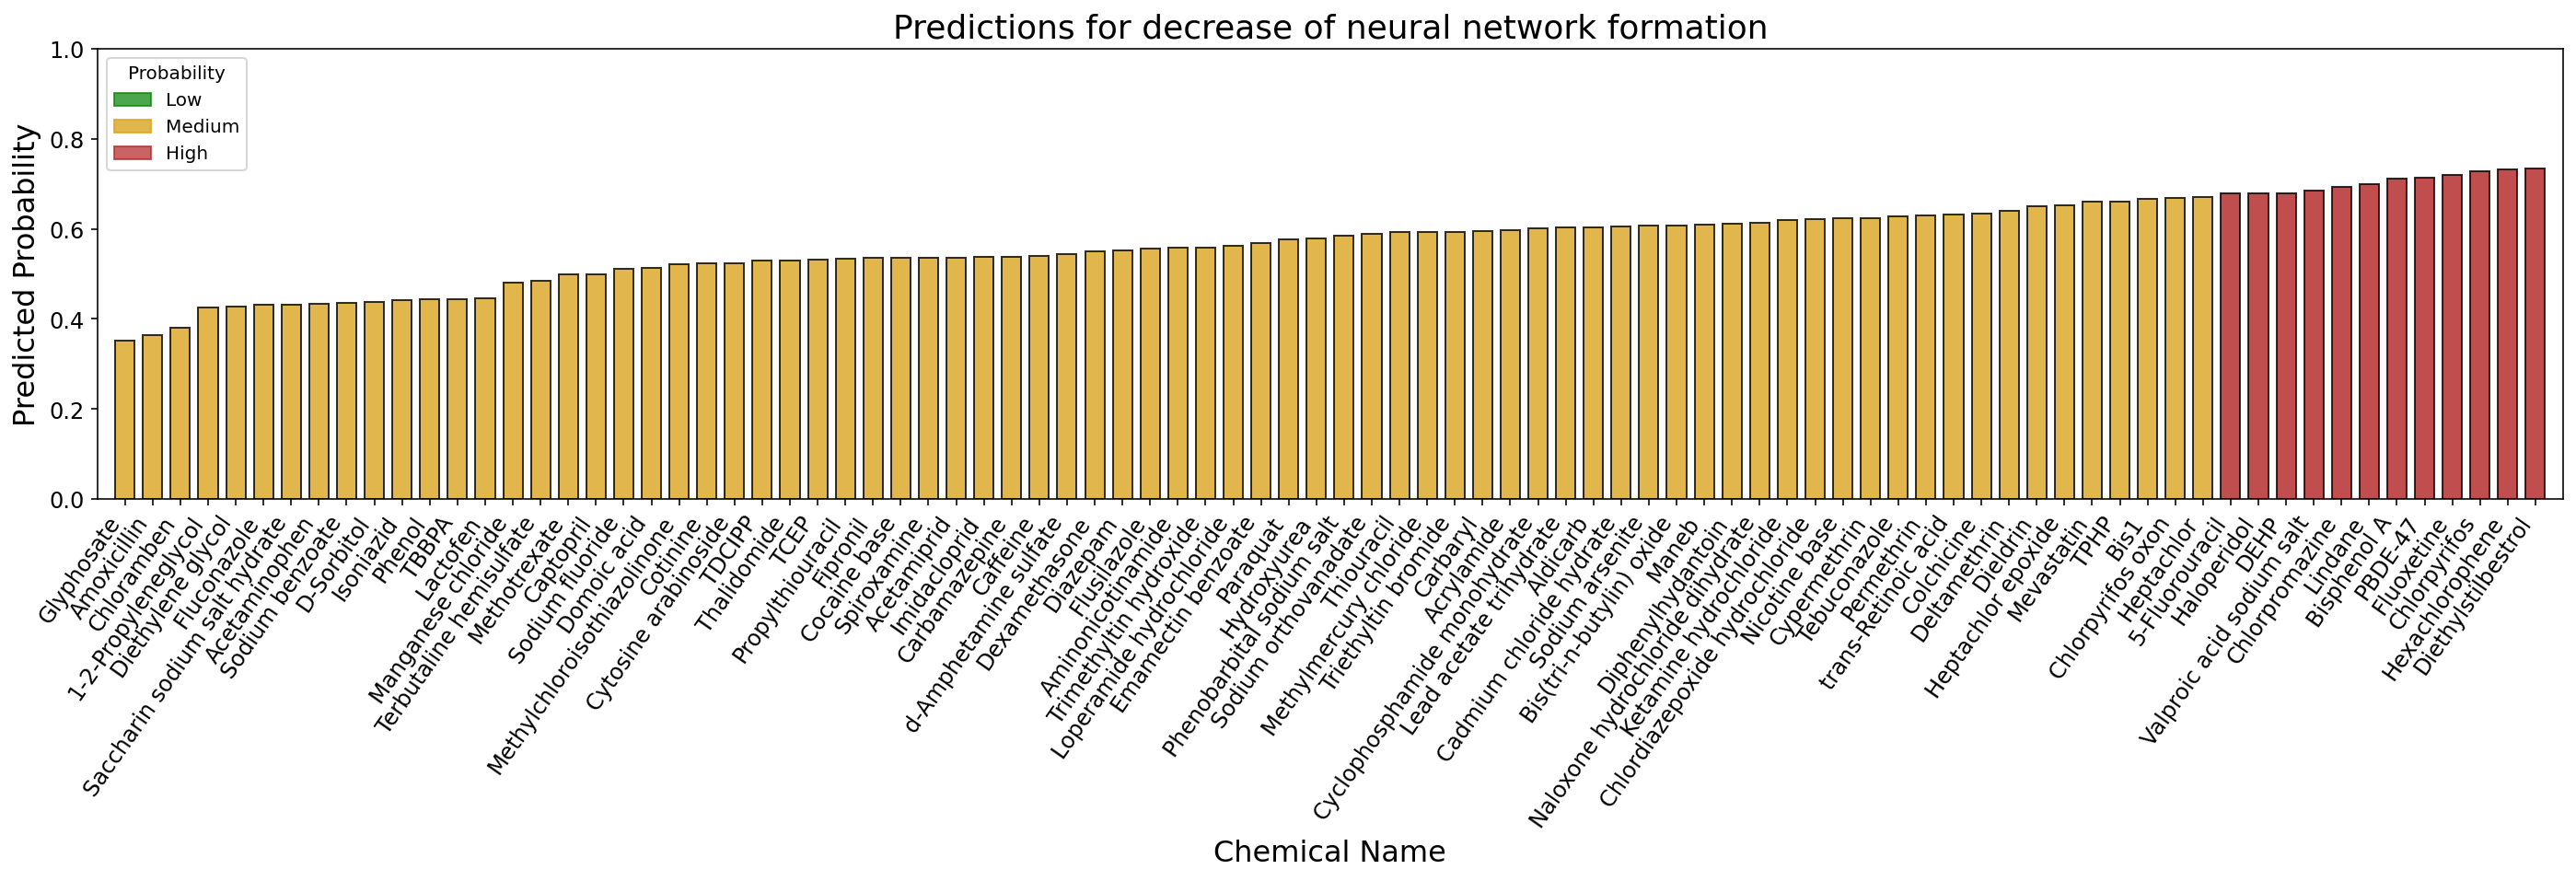

In [20]:
# --- Mean of posterior probabilities for NNF --- #
obs_nnf = np.squeeze(idata_hierar.posterior_predictive['y_obs_nnf'])
obs_pred = np.reshape(obs_nnf.values, (40000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .34] = 0
new_labeling[(avg_obs_pred >= .34) & (avg_obs_pred < .67)] = 1
new_labeling[avg_obs_pred >= .67] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]


fig, ax = plt.subplots(figsize=(24, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Chemical Name', fontsize=16)
ax.set_title("Predictions for decrease of neural network formation", fontsize=18)

ax.set_xlim([-1, 88])
ax.set_ylim([0, 1])

green_patch = mpatches.Patch(color='green', label='Low', alpha=0.7)
yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.8)
red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.7)
plt.legend(handles=[green_patch, yellow_patch, red_patch], title="Probability")

fig.autofmt_xdate(rotation=55);

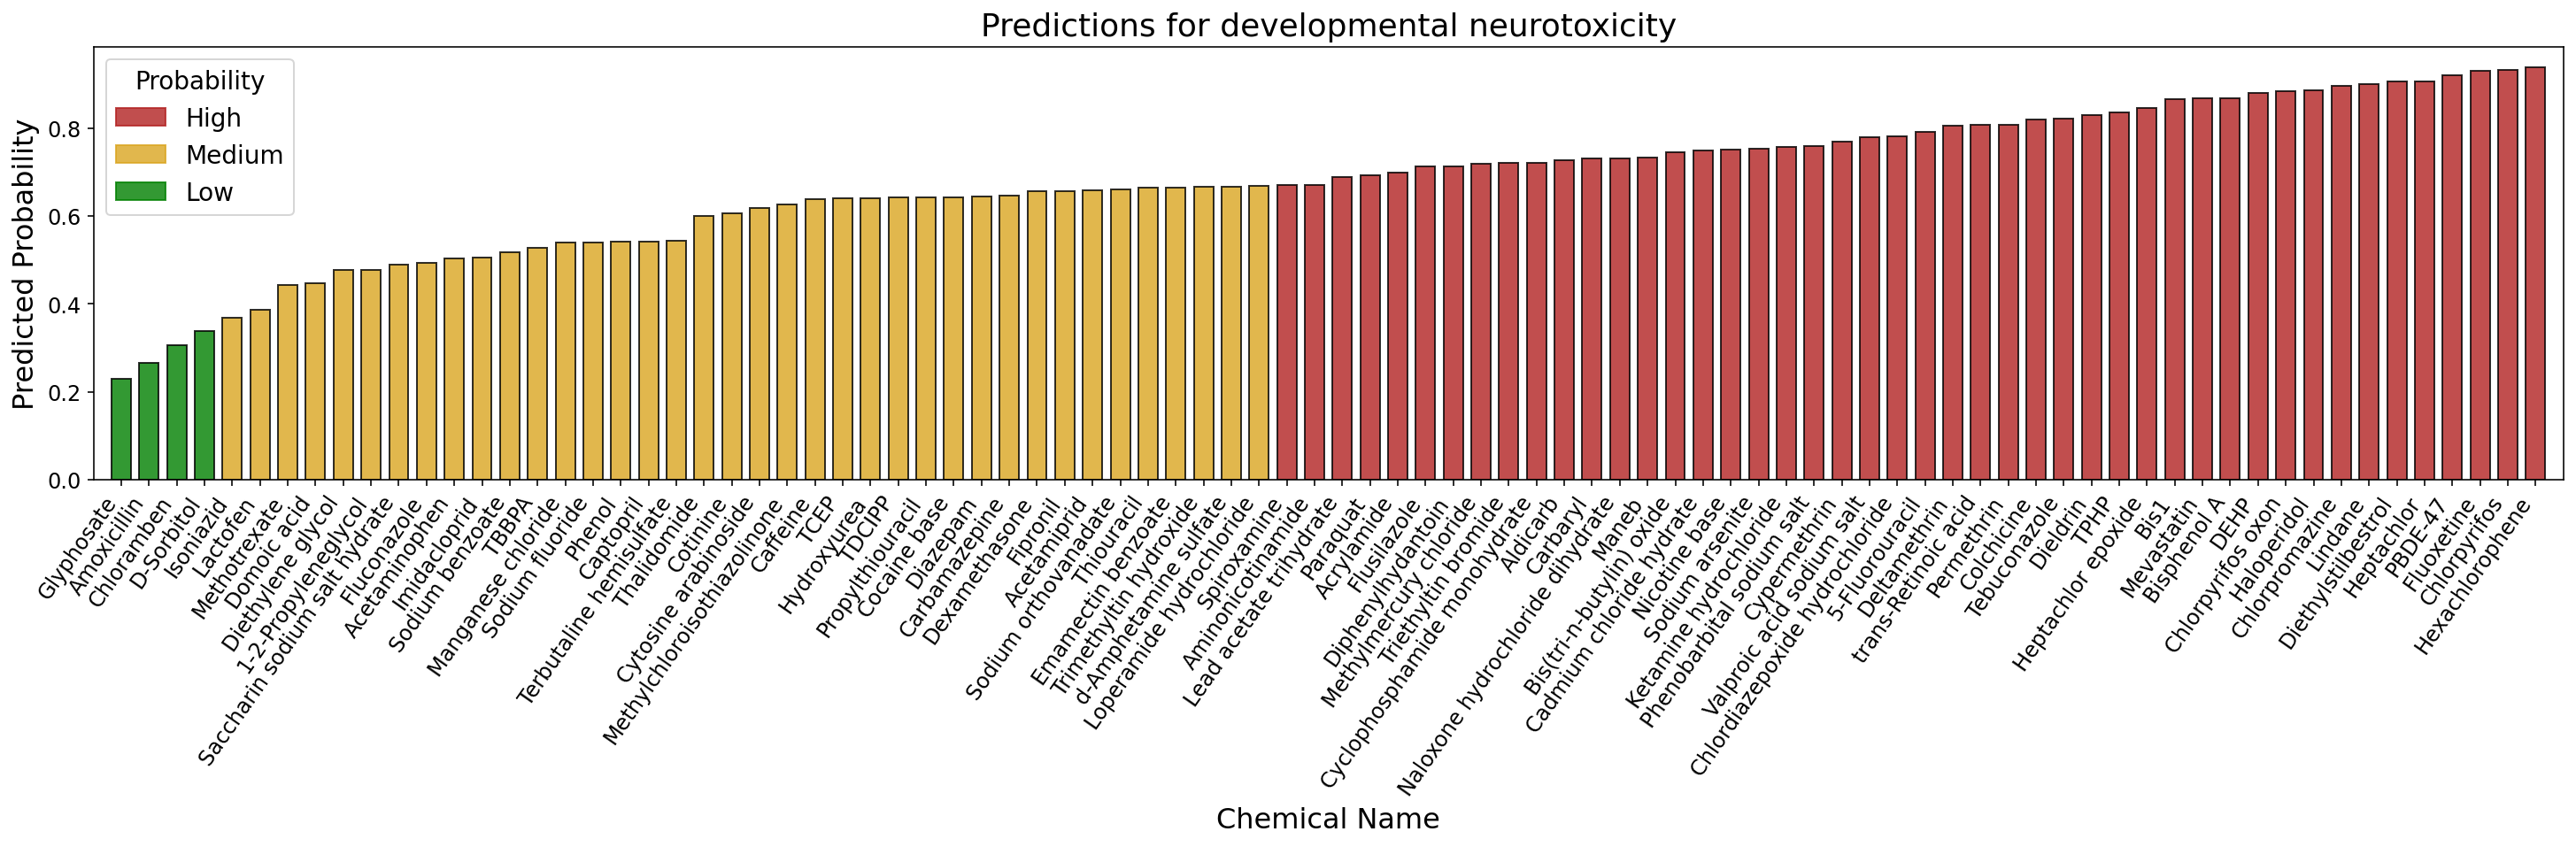

In [21]:
# --- Mean of posterior probabilities for DNT --- #
obs_dnt = np.squeeze(idata_hierar.posterior_predictive['y_obs_dnt'])
obs_pred = np.reshape(obs_dnt.values, (40000, 88))
avg_obs_pred = obs_pred.mean(axis=0)
order = np.argsort(avg_obs_pred)

new_labeling = np.zeros(avg_obs_pred.shape, dtype=int)
new_labeling[avg_obs_pred < .34] = 0
new_labeling[(avg_obs_pred >= .34) & (avg_obs_pred < .67)] = 1
new_labeling[avg_obs_pred >= .67] = 2

cc = np.asarray(['green', 'goldenrod', 'firebrick'])
class_label = np.squeeze(new_labeling.astype(int))
color_label = cc[class_label]

fig, ax = plt.subplots(figsize=(25, 5))
ax.bar(np.arange(88), avg_obs_pred[order], color=color_label[order], alpha = 0.8, edgecolor='black', width=0.7)

ax.set_xticks(np.arange(88))
ax.set_xticklabels(ylabels[order], fontsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.set_ylabel('Predicted Probability', fontsize=16)
ax.set_xlabel('Chemical Name', fontsize=16)
ax.set_title("Predictions for developmental neurotoxicity", 
             fontsize=18)

ax.set_xlim([-1, 88])

green_patch = mpatches.Patch(color='green', label='Low', alpha=0.8)
yellow_patch = mpatches.Patch(color='goldenrod', label='Medium', alpha=0.8)
red_patch = mpatches.Patch(color='firebrick', label='High', alpha=0.8)
plt.legend(handles=[red_patch, yellow_patch, green_patch], title = 'Probability', title_fontsize=14, fontsize=14)

fig.autofmt_xdate(rotation=55);

In [22]:
# --- Save results --- #
post_pred_bdnf = np.squeeze(posterior_hierar['y_obs_bdnf']).mean(axis=0).round(2)
post_pred_syn = np.squeeze(posterior_hierar['y_obs_syn']).mean(axis=0).round(2)
post_pred_nnf = np.squeeze(posterior_hierar['y_obs_nnf']).mean(axis=0).round(2)
post_pred_dnt = np.squeeze(posterior_hierar['y_obs_dnt']).mean(axis=0).round(2)
post_pred = {'Chemical name': data['Chemical'],
             'CAS RN': data['CASRN'],
             'post_pred_bdnf': post_pred_bdnf, 
             'post_pred_syn': post_pred_syn,
             'post_pred_nnf': post_pred_nnf, 
             'post_pred_dnt': post_pred_dnt}
post_pred = pd.DataFrame(post_pred)
post_pred = post_pred.to_csv('../data/post_pred.csv', index=False)

[Back](#Content)

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Sep 10 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.26.0

pymc3     : 3.11.4
arviz     : 0.11.2
pandas    : 1.3.2
seaborn   : 0.11.0
theano    : 1.0.4
matplotlib: 3.3.1
numpy     : 1.21.2

Watermark: 2.2.0

